<a href="https://colab.research.google.com/github/gaezco/ASIG00202---Programacion-Avanzada---TP-Segundo-Modulo/blob/main/TP_Segundo_M%C3%B3dulo_Conessa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Setup

*importo todas las librerias que voy a utilizar.*

In [219]:
###############################################################################
# Importo todas las librerias que voy a usar
###############################################################################

# Libreria para la BD

import sqlite3

# Libreria de graficos

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# Libreria de manipulacion de datos para analisis

import pandas as pd
import numpy as np

# Libreria para poder armar los graficos geograficos de caba

import json
import requests
import geopandas as gpd                           # Necesario para calcular centroides
from shapely.geometry import shape

# Libreria para importar el archivo excel con la fuente de datos

# el archivo a importar lo obtuve de la pagina del gobierno de la ciudad,
# contiene los datos de todas las Farmacias de CABA
# URL: https://data.buenosaires.gob.ar/dataset/farmacias
# Lo descargo en fromato farmacias.xlsx

from google.colab import files
uploaded = files.upload()


# 2 - Creación de la BD

*Creo la BD usando Sqllite y luego subo a esa base de datos el dataset a utilizar* ***farmacias.xlxs***

In [220]:
# 2.1 - Creo la conexion a la base de datos
conexion = sqlite3.connect("tp_conessa.db")
cursor = conexion.cursor()

# 2.2 - Leo el excel seleccionado para el trabajo que se importo en el apartado (1)
df = pd.read_excel("farmacias.xlsx")

# 2.3 Cargar el excel seleccionado en una tabla llamada 'Tabla_Farmacias'
df.to_sql("Tabla_Farmacias", conexion, if_exists='replace', index=False)


1240

# 3 - Calculo KPI

*Calculo los KPI relevantes del dataset*. *Luego los voy a llevar al dashboard a implementar*

In [221]:
###############################################################################
# Calculo los datos para armar los KPIs
###############################################################################

# 3.1 Consulto los campos que necesito de tabla llamada 'Tabla_Farmacias'
#  para calcular la cantidad de farmacias por comuna

cursor.execute("SELECT objeto,barrio, comuna FROM Tabla_Farmacias")
kpis_farmacias = cursor.fetchall()

# 3.2 Cargo los datos que quiero en un DataFrame de pandas
columnas = ['farmacia','barrio','comuna']
df_kpi = pd.DataFrame(kpis_farmacias, columns=columnas)

# 3.3 Calculo los KPIs relevantes
Cantidad_total_Farmacias = df_kpi['farmacia'].count()
Cantidad_Comunas = df_kpi['comuna'].nunique()
Cantidad_Barrios = df_kpi['barrio'].nunique()

Promedio_Farmacias_por_Comuna = Cantidad_total_Farmacias/Cantidad_Comunas
Promedio_Farmacias_por_Barrio = Cantidad_total_Farmacias/Cantidad_Barrios


###############################################################################
# Pruebo como grafican estos KPI para probar
###############################################################################

# 3.4 armo el encabezado
fig_kpi = make_subplots(rows=1, cols=3, specs=[[{"type":"indicator"}]*3])

# 3.5 armo las etiquetas de cada KPI
fig_kpi.add_trace(go.Indicator(
    mode="number",
    value=Cantidad_total_Farmacias,
    title={
        "text": f"Total de Farmacias",
        "font": {"size": 20}
    },
    number={
        "valueformat": ",.0f",
        "font": {"size": 36}
    },
    domain={'row': 0, 'column': 0}
), row=1, col=1)

fig_kpi.add_trace(go.Indicator(
    mode="number",
     value=Promedio_Farmacias_por_Comuna,
     title={
        "text": f"Cant Farmacias/Comuna",
        "font": {"size": 20}
    },
    number={
        "valueformat": ",.0f",
        "font": {"size": 36}
    }
), row=1, col=2)

fig_kpi.add_trace(go.Indicator(
    mode="number",
    value=Promedio_Farmacias_por_Barrio,
    title={
        "text": f"Cant Farmacias/Barrio",
        "font": {"size": 20}
    },
    number={
        "valueformat": ",.0f",
        "font": {"size": 36}
    }
), row=1, col=3)

# 3.6 grafico los KPI
fig_kpi.update_layout(title_text="KPIs relevantes de Farmacias en CABA")
fig_kpi


# 4 - Grafico de Barras
*Armo un grafico de barras con la cantidad de farmacias por comunas. Luego voy a utilizar este grafico en la consutruccion del Dashboard*

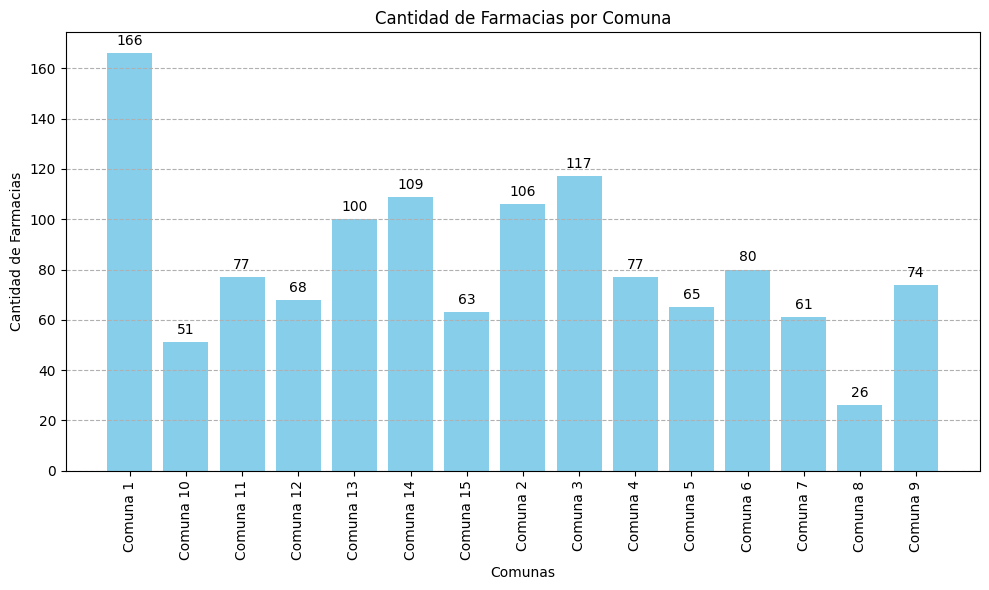

In [222]:
###############################################################################
# Calculo los datos para armar el grafico de barras
###############################################################################

# 4.1 Consulto los campos que necesito de tabla llamada 'Tabla_Farmacias'
#  para calcular la cantidad de farmacias por comuna

cursor.execute("SELECT objeto, comuna FROM Tabla_Farmacias")
datos_farmacias = cursor.fetchall()

# 4.2 Cargo los datos que quiero en un DataFrame de pandas
columnas = ['farmacia','comuna']
df = pd.DataFrame(datos_farmacias, columns=columnas)

# 4.3 Calculo la cantidad de farmacias por comuna
df_comunas = df.groupby('comuna', as_index=False).size()


###############################################################################
# Armo el grafico para ver como se visualiza antes de llevarlo al Dashboard
###############################################################################

# 4.4 Armo el grafico
plt.figure(figsize=(10, 6))
barras = plt.bar(df_comunas['comuna'], df_comunas["size"], color='skyblue')

# 4.5 calculo las etiquetas de texto para cada barra.
for barra in barras:
    altura = barra.get_height()  # El valor de la barra (la cantidad)

    plt.text(
        # La posición X: el centro de la barra
        barra.get_x() + barra.get_width() / 2,

        # La posición Y: la altura de la barra + un pequeño margen (e.g., 2 unidades)
        altura + 2,

        # El texto a mostrar (la altura convertida a string)
        str(int(altura)),

        # Alineación horizontal: centrado en la posición X
        ha='center',

        # Alineación vertical: ancla el texto en la parte inferior de la coordenada Y
        va='bottom',

        fontsize=10,
        color='black'
    )

# 4.6 armo el grafico de barras

plt.title('Cantidad de Farmacias por Comuna')
plt.xlabel('Comunas')
plt.ylabel('Cantidad de Farmacias')
plt.xticks(rotation=90) # Roto las etiquetas de la Comuna 90 grados para leerlas bien
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()



# 5 - Grafico por barrios de CABA

*Armo un grafico geofrafico con la cantida de farmacias por comuna. Luego voy a utilizar este grafico en la consutruccion del Dashboard*

In [223]:
###############################################################################
# Cargo los datos para poder armar el dashboard por Barrio
###############################################################################


# 5.1 Cargo el GeoJSON de barrios porteños pata tener todos los poligonos
url = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/barrios/barrios.geojson'
geojson = requests.get(url).json()

# 5.2 Crear un DataFrame con datos de farmacias por barrio
cursor.execute("SELECT objeto, UPPER(barrio) FROM Tabla_Farmacias")
farmacias_barrios = cursor.fetchall()

# 5.3 Cargo los datos que quiero en un DataFrame de pandas
columnas = ['farmacia','barrio']
df5 = pd.DataFrame(farmacias_barrios, columns=columnas)

# 5.4 Calculo la cantidad de farmacias por barrio
df_barrio = df5.groupby('barrio', as_index=False).size()
df_barrio.rename(columns={'size': 'Cantidad_Farmacias'}, inplace=True)

###############################################################################
# Armo el grafico
###############################################################################

# NOTA: Aca tuve un problema con la barra lateral donde se detallan los colores
# cuando quiero sumar este grafico al dashboard me descompagina todo por esa
# Columna asi que la elimino, junto con el codido de colores por simplicidad

# 5.5 Graficar con Plotly el mapa de con los poligonos y colores por barrio

fig_barrio = px.choropleth_mapbox(
    df_barrio,
    geojson=geojson,
    locations='barrio',                      # Columna con los nombres de los barrios
    featureidkey='properties.BARRIO',        # Campo clave en el GeoJSON para la unión
    #color='Cantidad_Farmacias',             # Columna que define el color (la cantidad). LO OCULTO PORQUE ME ROMPE EL DASHBOARD
    #color_continuous_scale='Blues',
    mapbox_style='carto-positron',
    zoom=10,                                 # Un zoom un poco mayor para CABA
    center={"lat": -34.61, "lon": -58.44},
    opacity=0.7,
    title="Cantidad de Farmacias por Barrio en CABA"
)

###############################################################################
# Le sumo al grafico la cantidad de farmacias por Barrios
###############################################################################

# 5.6 Creo los numeros para mostrar en el centro de cada barrio

barrio_geometrias = {
    feature['properties']['BARRIO']: shape(feature['geometry'])
    for feature in geojson['features']
}
gdfs_barrios = gpd.GeoDataFrame(
    df_barrio,
    geometry=[barrio_geometrias.get(b) for b in df_barrio['barrio']]
)

# 5.7 Calcular el centroide (latitud y longitud) de cada barrio
gdfs_barrios['lon'] = gdfs_barrios.geometry.centroid.x
gdfs_barrios['lat'] = gdfs_barrios.geometry.centroid.y

# 5.8 Añadimos una capa de texto usando go.Scattermapbox
fig_barrio = fig_barrio.add_trace(go.Scattermapbox(
    lat=gdfs_barrios['lat'],
    lon=gdfs_barrios['lon'],
    mode='text', # Indica que el modo es solo texto
    text=gdfs_barrios['Cantidad_Farmacias'].astype(str), # El texto a mostrar
    textfont=dict(size=10, color='black'),
    textposition='middle center',

    showlegend=False
))

###############################################################################
# Muestro el grafico
###############################################################################

fig_barrio.show()

# 6 - Mapa geografico con las ubicaciones de las farmacias
*Armo un grafico usando la latitud y longitud de cada farmacia para posicionarla en un mapa de CABA. Luego voy a utilizar este grafico en la consutruccion del Dashboard*



In [224]:
###############################################################################
# Cargo los datos para poder armar el dashboard por latitud-longitud
###############################################################################


# 6.1 Cargo el GeoJSON de comunas
url = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/barrios/barrios.geojson'
geojson = requests.get(url).json()

# 6.2 Crear un DataFrame con datos de farmacias por barrio
cursor.execute("SELECT lat, long, objeto, comuna FROM Tabla_Farmacias")
farmacias_comunas = cursor.fetchall()

# 6.3 Cargo los datos que quiero en un DataFrame de pandas
columnas = ['Latitud','Longitud','Farmacia','Comuna']
df_posiciones = pd.DataFrame(farmacias_comunas, columns=columnas)

# 6.4 cargo los datos dosicion de las farmacias
data = {
    'nombre': df_posiciones['Farmacia'],
    'latitud': df_posiciones['Latitud'],
    'longitud': df_posiciones['Longitud'],
    'comuna': df_posiciones['Comuna']
}
df_farmacias = pd.DataFrame(data)


###############################################################################
# Armo el grafico
###############################################################################

# 6.5 Armo el Scareplot

fig_farmacia = go.Figure()  # Inicializo la figura para luego editarla

fig_farmacia.add_trace(go.Scattermapbox(
    lat=df_farmacias['latitud'],
    lon=df_farmacias['longitud'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=8,
        color='red', # Color de los marcadores
        opacity=0.5
    ),
    text=df_farmacias['nombre'], # Texto que aparece al pasar el mouse
    hoverinfo='text',
    #name='Farmacias'
))

# 6.6 Configuración del Layout del Mapa
fig_farmacia.update_layout(
    title='Farmacias en Capital Federal (CABA)',
    mapbox_style="open-street-map",
    mapbox_zoom=10.5,
    mapbox_center={"lat": -34.61, "lon": -58.44},
    # margin={"r":0,"t":40,"l":0,"b":0}
)

###############################################################################
# Muestro el grafico
###############################################################################

fig_farmacia.show()


# 7 - DASHBOARD

*Armo el dashboard con los graficos utilizados*

In [226]:
###############################################################################
# Defino dashboard con subplots
###############################################################################

dashboard = make_subplots(
    rows=4, cols=3,
    specs=[
        [{"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}],      # Fila 1: Detallo los KPIS
        [{"type": "xy", "colspan": 3}, None, None],                                 # Fila 2: Grafico de Barras
        [{"type": "mapbox", "colspan": 3}, None, None],                             # Fila 3: Mapa de Farmacias por Barrios
        [{"type": "mapbox", "colspan": 3}, None, None]                              # Fila 4 Mapa Geografico de Farmacias
    ],
    row_heights=[0.1, 0.2, 0.35, 0.35],  # Fila superior más chica
)

###############################################################################
# Redefino los componentes que voy a poner en el dashboard
###############################################################################

# Calculo los KPIs

Cantidad_total_Farmacias = df_kpi['farmacia'].count()
Cantidad_Comunas = df_kpi['comuna'].nunique()
Cantidad_Barrios = df_kpi['barrio'].nunique()

Promedio_Farmacias_por_Comuna = Cantidad_total_Farmacias/Cantidad_Comunas
Promedio_Farmacias_por_Barrio = Cantidad_total_Farmacias/Cantidad_Barrios

# Muestro los 3 KPIs

dashboard.add_trace(go.Indicator(
    mode="number",
    value=Cantidad_total_Farmacias,
    title={
        "text": f"Total de Farmacias",
        "font": {"size": 20}
    },
    number={
        "valueformat": ",.0f",
        "font": {"size": 36}
    },
    domain={'row': 0, 'column': 0},
), row=1, col=1)

dashboard.add_trace(go.Indicator(
    mode="number",
     value=Promedio_Farmacias_por_Comuna,
     title={
        "text": f"Cant Farmacias/Comuna",
        "font": {"size": 20}
    },
    number={
        "valueformat": ",.0f",
        "font": {"size": 36}
    }
), row=1, col=2)

dashboard.add_trace(go.Indicator(
    mode="number",
    value=Promedio_Farmacias_por_Barrio,
    title={
        "text": f"Cant Farmacias/Barrio",
        "font": {"size": 20}
    },
    number={
        "valueformat": ",.0f",
        "font": {"size": 36}
    }
), row=1, col=3)

# Armo el grafico de barras para mostrar

fig_barras_plotly = go.Bar(
    x=df_comunas['comuna'],
    y=df_comunas["size"],
    marker_color='skyblue',
    name='Farmacias por Comuna',

    text=df_comunas["size"],                                                      # Asigno la lista de valores a mostrar
    textposition='inside',                                                        # Coloca el texto en la parte superior de la barra
    textfont={'size': 10, 'color': 'black'}                                       # Opcional: Ajusta el tamaño y color del texto
)

dashboard.add_trace(fig_barras_plotly, row=2, col=1)

# Armo los dos Mapa para mostrar

for trace in fig_barrio.data:
    dashboard.add_trace(trace, row=3, col=1)

for trace in fig_farmacia.data:
    dashboard.add_trace(trace, row=4, col=1)


###############################################################################
# Ajusto las propiedades graficas de cada elemento para que se muestren
###############################################################################

dashboard.update_layout(

    # TÍTULO PRINCIPAL DEL DASHBOARD

    title_text="Dashboard de Farmacias | Distribución Geográfica",
    height=1200,

    # Oculto las leyendas automaticas del grafico xq me traen problemas
    showlegend=False,

    # Cambio el color de fondo del grafico de Barras

    plot_bgcolor='ghostwhite',  # Fondo del área del gráfico en blanco
    paper_bgcolor='white', # Fondo de toda la figura en blanco


    # Ajusto de posicion del Mapa de Barrios

    mapbox = dict(
        style=fig_barrio.layout.mapbox.style,
        #zoom=fig_barrio.layout.mapbox.zoom,
        center=fig_barrio.layout.mapbox.center,
        zoom=9.6,
        domain={
            'x': [0.05, 0.95],                                                  # Ajusto el ancho del mapa
            'y': [0.3, 0.55]
        }
    ),

    # Ajusto de posicion del Mapa geografico

    mapbox2 = dict(
        style=fig_farmacia.layout.mapbox.style,
        # zoom=fig_farmacia.layout.mapbox.zoom,
        center=fig_farmacia.layout.mapbox.center,
        zoom=9.6,                                                               # Ajusto el zoom del grafico
        domain={
            'x': [0.05, 0.95],                                                  # Ajusto el ancho del mapa
            'y': [0.0, 0.25]                                                    # Ajusto el alto del mapa para que cuadre
        }
    ),

    # Agrego los Bordes a los KPI para resaltar

    shapes=[
        # Recuadro para KPI 1 (Columna 1)
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, x1=0.3,
            y0=0.93, y1=1.02,          # Ajustar estos valores de alto de la celda
            fillcolor="#f0f0f0",      # Color de fondo suave
            line={"color": "lightgray", "width": 1}, # Borde
            layer="below"
        ),
        # Recuadro para KPI 2 (Columna 2)
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0.32, x1=0.68,
            y0=0.93, y1=1.02,                                                   # Ajusto los valores de alto de la celda
            fillcolor="#f0f0f0",
            line={"color": "lightgray", "width": 1},
            layer="below"
        ),
        # Recuadro para KPI 3 (Columna 3)
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0.7, x1=1.02,
            y0=0.93, y1=1.02,                                                   # Ajusto los valores de alto de la celda
            fillcolor="#f0f0f0",
            line={"color": "lightgray", "width": 1},
            layer="below"
        ),
    ],


    # Ajusto las propiedades del grafico de Barras

    xaxis1={
        'title': 'Comunas',
        'tickangle': -90,
        'showgrid': True,
        'zeroline': False,
        'linecolor': 'black',
        'linewidth': 1
    },

    yaxis1={
        'title': 'Cantidad de Farmacias',
        'showgrid': True,
        'gridcolor': '#e0e0e0',
        'gridwidth': 1,
        'zeroline': True,
        'zerolinecolor': 'lightgray',
    },


###############################################################################
# Ajusto los titulos que se van a motrar en cada grafico
###############################################################################


    annotations=[
        # Título Barras (Fila 2)
        dict(text='Cantidad de Farmacias por Comuna', xref='paper', yref='paper',
             x=0.5, y=0.88, showarrow=False, font=dict(size=18)),
        # Título Mapa 1 (Fila 3)
        dict(text='Mapa de Farmacias por Barrios', xref='paper', yref='paper',
             x=0.5, y=0.57, showarrow=False, font=dict(size=18)),
        # Título Mapa 2 (Fila 4)
        dict(text='Mapa Geográfico de Farmacias', xref='paper', yref='paper',
             x=0.5, y=0.26, showarrow=False, font=dict(size=18))
    ]
)

###############################################################################
# Imprimo el Dashbard
###############################################################################


dashboard.show()